# Streamlined XRD Phase Analysis with DARA

**Workflow:**
1. **Part 1**: Define XRD pattern and setup
2. **Part 2**: Load CIF files (database + custom) → Phase Search → Visualize Solutions
3. **Part 3**: Advanced Refinement with user-selected solution

---

## Part 1: XRD Pattern and Setup

Define your experimental pattern and configure analysis parameters.

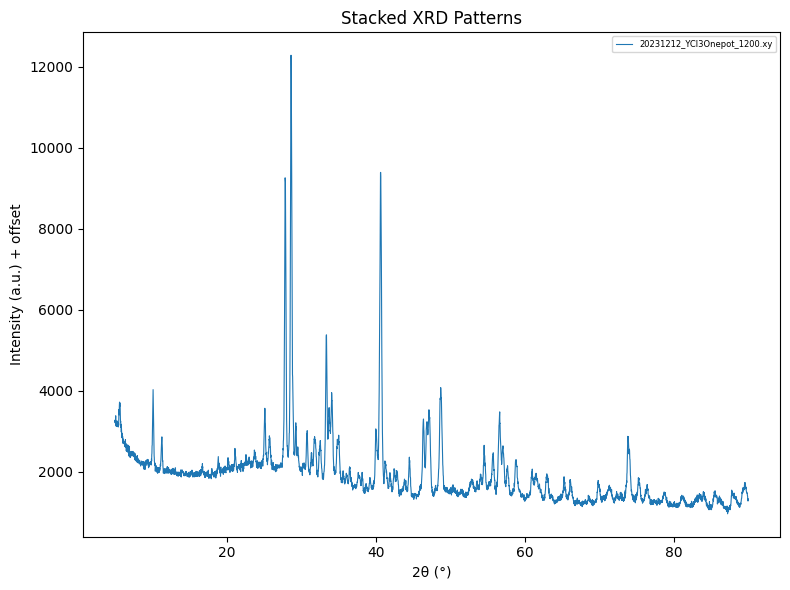

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Folder containing your .xy files
folder = r"D:\XRD_Analysis\DTMA_YMoO3"

files = sorted(glob.glob(os.path.join(folder, "*.xy")))

plt.figure(figsize=(8, 6))

offset = 0
for f in files:
    data = np.loadtxt(f)
    x, y = data[:, 0], data[:, 1]
    plt.plot(x, y + offset, lw=0.8, label=os.path.basename(f))
    offset += max(y) * 1.5  # vertical spacing between patterns

plt.xlabel("2θ (°)")
plt.ylabel("Intensity (a.u.) + offset")
plt.title("Stacked XRD Patterns")
plt.legend(fontsize=6, loc='upper right')
plt.tight_layout()
plt.show()


In [2]:
import sys
from pathlib import Path
import pandas as pd
import warnings

# Suppress pymatgen CIF parsing warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pymatgen')

# Import DARA
from dara import search_phases
from dara.refine import do_refinement_no_saving
from pymatgen.core import Structure

# Import database tools
repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root / 'scripts'))
from dara_adapter import prepare_phases_for_dara

print("✅ Libraries imported successfully!")
print(f"📁 Repository root: {repo_root}")

✅ Libraries imported successfully!
📁 Repository root: d:\Haiwen\Code_Repositories\dara


In [3]:
# ========== XRD PATTERN CONFIGURATION ==========
# Define your XRD pattern file (absolute path recommended)
# pattern_path = str(repo_root / "notebooks" / "tutorial_data" / "GeO2-ZnO_700C_60min.xrdml")
pattern_path = r"D:\XRD_Analysis\DTMA_YMoO3\20231212_YCl3Onepot_1200.xy"

# Chemical system information
chemical_system = "Y-Mo-O"  # ← FIXED: Use hyphens, not commas
required_elements = ['Y', 'Mo', 'O']  # Define the chemical system

# IMPORTANT: The filter now includes ALL subsystems in this chemical system:
#   - Unary: K, Sn, Te
#   - Binary: KSn, KTe, SnTe
#   - Ternary: KSnTe
# And excludes phases containing ANY other elements.
# This is the correct behavior for phase search in a chemical system.

exclude_elements = []  # Additional elements to explicitly exclude (optional)

# Instrument parameters
wavelength = "Cu"  # "Cu", "Co", "Mo", or custom wavelength
instrument_profile = "Aeris-fds-Pixcel1d-Medipix3"  # Your instrument profile

print(f"📊 Pattern: {Path(pattern_path).name}")
print(f"🧪 Chemical system: {chemical_system}")
print(f"🔬 Elements: {required_elements}")
print(f"   → Includes all subsystems: unary, binary, ternary")
print(f"   → Excludes phases with other elements")
print(f"⚙️  Wavelength: {wavelength}")
print(f"⚙️  Instrument: {instrument_profile}")

📊 Pattern: 20231212_YCl3Onepot_1200.xy
🧪 Chemical system: Y-Mo-O
🔬 Elements: ['Y', 'Mo', 'O']
   → Includes all subsystems: unary, binary, ternary
   → Excludes phases with other elements
⚙️  Wavelength: Cu
⚙️  Instrument: Aeris-fds-Pixcel1d-Medipix3


In [4]:
# ========== WORKING DIRECTORY SETUP ==========
import os

# Create working directory for outputs
user_docs = Path(os.path.expanduser("~")) / "Documents"
work_dir = user_docs / "dara_analysis" / chemical_system.replace('-', '')
work_dir.mkdir(parents=True, exist_ok=True)

# Create subdirectories
custom_cif_dir = work_dir / "custom_cifs"
reports_dir = work_dir / "reports"
custom_cif_dir.mkdir(exist_ok=True)
reports_dir.mkdir(exist_ok=True)

print(f"📁 Working directory: {work_dir}")
print(f"   └─ Custom CIFs: {custom_cif_dir}")
print(f"   └─ Reports: {reports_dir}")

# Change to repo root for database CIF access
original_cwd = os.getcwd()
os.chdir(repo_root)
print(f"\n✅ Working directory set to repo root: {os.getcwd()}")

📁 Working directory: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO
   └─ Custom CIFs: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\custom_cifs
   └─ Reports: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\reports

✅ Working directory set to repo root: d:\Haiwen\Code_Repositories\dara


---

## Part 2: Load CIFs and Phase Search

### 💡 Understanding Chemical System Filtering

**New Default Behavior (Improved):**
When you specify `required_elements = ['Ge', 'Zn', 'O']`, the filter now correctly includes **all subsystems**:
- **Unary**: Ge, Zn, O
- **Binary**: GeO, ZnO, GeZn (and their variants)
- **Ternary**: GeZnO (and variants)

And **excludes** any phases containing other elements (Fe, Cu, Al, etc.).

This is the **correct behavior** for XRD phase search in a chemical system, as you want to consider all possible phases that could form from your starting materials.

---

### 2.1 Select Database and Load CIF Files

In [5]:
# ========== DATABASE SELECTION ==========
# Choose ONE database to use:
# "COD"   - Crystallography Open Database (501,975 structures)
# "ICSD"  - Inorganic Crystal Structure Database (229,487 structures)
# "MP"    - Materials Project (169,385 structures, exp + theory)
# "NONE"  - Use only custom CIFs

DATABASE = "COD"  # ← Change this to your preferred database

# ========== MATERIALS PROJECT OPTIONS (only if DATABASE = "MP") ==========
MP_EXPERIMENTAL_ONLY = False  # True = experimental only, False = exp + stable theory
MP_MAX_E_ABOVE_HULL = 0.1     # Maximum energy above hull (eV/atom) for theoretical structures

# ========== LOAD DATABASE CIFs ==========
database_cifs = []

if DATABASE == "COD":
    cod_index_path = repo_root / 'indexes' / 'cod_index_filled.parquet'
    print(f"📂 Loading COD database...")
    print(f"   Filtering for {chemical_system} chemical system")
    print(f"   → Includes: all subsystems (unary, binary, ternary, etc.)")
    print(f"   → Excludes: phases with other elements")
    database_cifs = prepare_phases_for_dara(
        index_path=cod_index_path,
        required_elements=required_elements,
        exclude_elements=exclude_elements,
        max_phases=500  # Limit for performance
    )
    print(f"✅ COD: Found {len(database_cifs)} phases")

elif DATABASE == "ICSD":
    icsd_index_path = repo_root / 'indexes' / 'icsd_index_filled.parquet'
    print(f"📂 Loading ICSD database...")
    print(f"   Filtering for {chemical_system} chemical system")
    print(f"   → Includes: all subsystems (unary, binary, ternary, etc.)")
    print(f"   → Excludes: phases with other elements")
    database_cifs = prepare_phases_for_dara(
        index_path=icsd_index_path,
        required_elements=required_elements,
        exclude_elements=exclude_elements,
        max_phases=500
    )
    print(f"✅ ICSD: Found {len(database_cifs)} phases")

elif DATABASE == "MP":
    mp_index_path = repo_root / 'indexes' / 'mp_index.parquet'
    print(f"📂 Loading Materials Project database...")
    print(f"   Filtering for {chemical_system} chemical system")
    print(f"   → Includes: all subsystems (unary, binary, ternary, etc.)")
    print(f"   → Excludes: phases with other elements")
    database_cifs = prepare_phases_for_dara(
        index_path=mp_index_path,
        required_elements=required_elements,
        exclude_elements=exclude_elements,
        experimental_only=MP_EXPERIMENTAL_ONLY,
        include_theoretical=not MP_EXPERIMENTAL_ONLY,
        max_e_above_hull=MP_MAX_E_ABOVE_HULL,
        max_phases=500
    )
    status = "experimental only" if MP_EXPERIMENTAL_ONLY else f"exp + theory (E_hull ≤ {MP_MAX_E_ABOVE_HULL} eV)"
    print(f"✅ MP ({status}): Found {len(database_cifs)} phases")

elif DATABASE == "NONE":
    print(f"⚠️  No database selected - will use custom CIFs only")

else:
    raise ValueError(f"Invalid DATABASE: {DATABASE}. Choose 'COD', 'ICSD', 'MP', or 'NONE'")

# Show examples
if len(database_cifs) > 0:
    print(f"\n📋 Example database CIFs:")
    for cif in database_cifs[:5]:
        print(f"   - {Path(cif).name}")
    if len(database_cifs) > 5:
        print(f"   ... and {len(database_cifs) - 5} more")

📂 Loading COD database...
   Filtering for Y-Mo-O chemical system
   → Includes: all subsystems (unary, binary, ternary, etc.)
   → Excludes: phases with other elements
✅ COD: Found 70 phases

📋 Example database CIFs:
   - 1512521.cif
   - 1512527.cif
   - 1512552.cif
   - 1513300.cif
   - 1521062.cif
   ... and 65 more


In [6]:
# ========== LOAD CUSTOM CIF FILES ==========
# Automatically scan custom CIF directory
custom_cif_files = list(custom_cif_dir.glob("*.cif"))
custom_cifs = [str(p) for p in custom_cif_files]

print(f"📂 Custom CIF directory: {custom_cif_dir}")
print(f"📄 Custom CIFs found: {len(custom_cifs)}")

if len(custom_cifs) > 0:
    print(f"\n📋 Custom CIF files:")
    for cif in custom_cifs:
        print(f"   - {Path(cif).name}")
else:
    print(f"\n💡 Tip: Add your own .cif files to {custom_cif_dir} to include them in phase search")

# ========== COMBINE ALL CIFs ==========
all_cif_paths = database_cifs + custom_cifs

print(f"\n" + "="*70)
print(f"📊 TOTAL PHASE SUMMARY")
print(f"="*70)
print(f"Database ({DATABASE}): {len(database_cifs)} phases")
print(f"Custom CIFs:           {len(custom_cifs)} phases")
print(f"─" * 70)
print(f"TOTAL:                 {len(all_cif_paths)} phases")
print(f"="*70)

if len(all_cif_paths) == 0:
    print(f"\n⚠️  WARNING: No CIF files to search! Add database or custom CIFs.")

📂 Custom CIF directory: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\custom_cifs
📄 Custom CIFs found: 0

💡 Tip: Add your own .cif files to C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\custom_cifs to include them in phase search

📊 TOTAL PHASE SUMMARY
Database (COD): 70 phases
Custom CIFs:           0 phases
──────────────────────────────────────────────────────────────────────
TOTAL:                 70 phases


### 2.2 Run Phase Search

### 🔍 Diagnostic: Check XRD Pattern Data

Before running the search, let's verify your XRD pattern is valid.

✅ Successfully loaded: 20231212_YCl3Onepot_1200.xy
   Data shape: (4305, 2)
   2θ range: 5.00° to 90.00°
   Intensity range: 957.0 to 12286.0
   Number of points: 4305


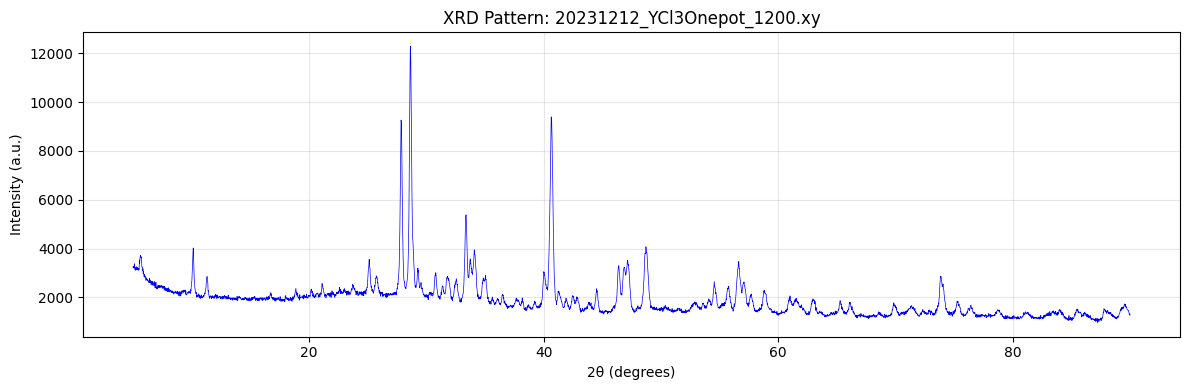


🔍 Diagnostic checks:
   ✅ Intensity range looks good
   ✅ Sufficient data points
   ✅ 2θ range is adequate


In [7]:
# ========== DIAGNOSTIC: CHECK XRD PATTERN ==========
import numpy as np
import matplotlib.pyplot as plt

# Read the XY file
try:
    data = np.loadtxt(pattern_path)
    
    print(f"✅ Successfully loaded: {Path(pattern_path).name}")
    print(f"   Data shape: {data.shape}")
    print(f"   2θ range: {data[:, 0].min():.2f}° to {data[:, 0].max():.2f}°")
    print(f"   Intensity range: {data[:, 1].min():.1f} to {data[:, 1].max():.1f}")
    print(f"   Number of points: {len(data)}")
    
    # Quick plot
    plt.figure(figsize=(12, 4))
    plt.plot(data[:, 0], data[:, 1], 'b-', linewidth=0.5)
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity (a.u.)')
    plt.title(f'XRD Pattern: {Path(pattern_path).name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Check for common issues
    print(f"\n🔍 Diagnostic checks:")
    
    if data[:, 1].max() < 100:
        print(f"   ⚠️  Low maximum intensity ({data[:, 1].max():.1f}) - might cause peak detection issues")
    else:
        print(f"   ✅ Intensity range looks good")
    
    if len(data) < 100:
        print(f"   ⚠️  Very few data points ({len(data)}) - might need finer sampling")
    else:
        print(f"   ✅ Sufficient data points")
    
    if data[:, 0].max() - data[:, 0].min() < 20:
        print(f"   ⚠️  Narrow 2θ range ({data[:, 0].max() - data[:, 0].min():.1f}°)")
    else:
        print(f"   ✅ 2θ range is adequate")
        
except Exception as e:
    print(f"❌ ERROR loading pattern file: {e}")
    print(f"\n💡 Possible solutions:")
    print(f"   1. Check if file exists: {Path(pattern_path).exists()}")
    print(f"   2. Verify file format (should be two columns: 2θ intensity)")
    print(f"   3. Check for text headers (should only contain numeric data)")

In [8]:
# ========== PHASE SEARCH ==========
print(f"🔍 Running phase search...")
print(f"   Pattern: {Path(pattern_path).name}")
print(f"   Phases: {len(all_cif_paths)}")
print(f"   Database: {DATABASE}")
print(f"\nThis may take several minutes...\n")

search_results = search_phases(
    pattern_path=pattern_path,
    phases=all_cif_paths,
    wavelength=wavelength,
    instrument_profile=instrument_profile,
)

print(f"\n{'='*70}")
print(f"✅ PHASE SEARCH COMPLETE")
print(f"{'='*70}")
print(f"Solutions found: {len(search_results)}")

if len(search_results) > 0:
    print(f"\n📊 Solution Quality (Rwp):")
    for i, result in enumerate(search_results[:10], 1):  # Show top 10
        rwp = result.refinement_result.lst_data.rwp
        n_phases = len(result.phases)
        print(f"   Solution {i}: Rwp = {rwp:.2f}% ({n_phases} phases)")
    if len(search_results) > 10:
        print(f"   ... and {len(search_results) - 10} more solutions")
else:
    print(f"\n⚠️  No solutions found. Try:")
    print(f"   - Adding more phases to the search")
    print(f"   - Checking if pattern file is correct")
    print(f"   - Verifying chemical system definition")

🔍 Running phase search...
   Pattern: 20231212_YCl3Onepot_1200.xy
   Phases: 70
   Database: COD

This may take several minutes...



2025-11-09 13:49:10,316	INFO worker.py:1927 -- Started a local Ray instance.


2025-11-09 13:49:14,084 INFO dara.search.tree Detecting peaks in the pattern.
2025-11-09 13:50:06,477 INFO dara.search.tree The wmax is automatically adjusted to 55.55.
2025-11-09 13:50:06,478 INFO dara.search.tree The intensity threshold is automatically set to 7.72 % of maximum peak intensity.
2025-11-09 13:50:06,479 INFO dara.search.tree Creating the root node.
2025-11-09 13:50:06,479 INFO dara.search.tree Refining all the phases in the dataset.
2025-11-09 14:08:57,557 INFO dara.search.tree The initial value of eps2 is automatically set to 0.000001_-0.05^0.05.
2025-11-09 14:08:57,559 INFO dara.search.tree Finished refining 70 phases, with 14 phases removed.
2025-11-09 14:08:57,560 INFO dara.search.tree Express mode is enabled. Grouping phases before starting.
2025-11-09 14:09:04,377 INFO dara.search.tree Phases are grouped into 45 groups. In express mode, only the best phase in each group will be considered during the search.
(_remote_expand_node pid=16580) 2025-11-09 14:09:04,432 I

### 2.3 Visualize Solutions and Extract Phase Information

View multiple solutions with detailed crystallographic information.

In [9]:
# Helper function to extract detailed phase information
def extract_phase_info(search_result):
    """
    Extract detailed crystallographic information from search result.
    
    Returns:
        DataFrame with phase details
    """
    from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
    
    phase_data = []
    phase_list = [phases[0] for phases in search_result.phases]  # Get best match for each phase
    lst_data = getattr(search_result.refinement_result, 'lst_data', None)
    phase_results_source = getattr(lst_data, 'phases_results', None)
    
    for idx, phase in enumerate(phase_list):
        try:
            structure = Structure.from_file(str(phase.path))
            phase_name = phase.path.stem
            
            # Resolve PhaseResult regardless of container type
            phase_result = None
            if isinstance(phase_results_source, dict):
                phase_result = phase_results_source.get(phase_name)
                if phase_result is None:
                    for key, value in phase_results_source.items():
                        key_name = None
                        if isinstance(key, (str, Path)):
                            key_name = Path(key).stem
                        else:
                            key_name = getattr(value, 'phase_name', None)
                        if key_name == phase_name:
                            phase_result = value
                            break
            elif isinstance(phase_results_source, (list, tuple)):
                if idx < len(phase_results_source):
                    phase_result = phase_results_source[idx]
            elif phase_results_source is not None:
                candidate_name = getattr(phase_results_source, 'phase_name', None)
                if candidate_name == phase_name:
                    phase_result = phase_results_source
            
            lattice = structure.lattice
            
            # Use SpacegroupAnalyzer to get crystal system
            sga = SpacegroupAnalyzer(structure)
            crystal_system = sga.get_crystal_system()
            
            # Determine source
            if str(custom_cif_dir) in str(phase.path):
                source = "Custom"
            else:
                source = DATABASE
            
            # Get weight percent - phase_result is a PhaseResult object with attributes
            weight_pct = 0.0
            if phase_result is not None:
                # Try to get gewicht (weight) from PhaseResult
                if hasattr(phase_result, 'gewicht') and phase_result.gewicht is not None:
                    if isinstance(phase_result.gewicht, (int, float)):
                        weight_pct = float(phase_result.gewicht)
                    elif isinstance(phase_result.gewicht, tuple):
                        weight_pct = float(phase_result.gewicht[0])
            
            phase_info = {
                'Source': source,
                'Phase Name': phase_name,
                'Formula': structure.composition.reduced_formula,
                'Space Group': structure.get_space_group_info()[0],
                'SG Number': structure.get_space_group_info()[1],
                'Crystal System': crystal_system,
                'a (Å)': f"{lattice.a:.4f}",
                'b (Å)': f"{lattice.b:.4f}",
                'c (Å)': f"{lattice.c:.4f}",
                'α (°)': f"{lattice.alpha:.2f}",
                'β (°)': f"{lattice.beta:.2f}",
                'γ (°)': f"{lattice.gamma:.2f}",
                'Weight %': f"{weight_pct:.2f}"
            }
            phase_data.append(phase_info)
        except Exception as e:
            print(f"⚠️  Could not extract info for {phase.path.name}: {e}")
    
    return pd.DataFrame(phase_data)

print("✅ Helper function defined")

✅ Helper function defined


In [10]:
# ========== VISUALIZE MULTIPLE SOLUTIONS ==========
# Set how many top solutions to display (change this number as needed)
NUM_SOLUTIONS_TO_SHOW = 3

if len(search_results) == 0:
    print("❌ No solutions available")
else:
    num_to_show = min(NUM_SOLUTIONS_TO_SHOW, len(search_results))
    
    print(f"{'='*70}")
    print(f"📊 DISPLAYING TOP {num_to_show} SOLUTIONS")
    print(f"{'='*70}\n")
    
    for i in range(num_to_show):
        solution = search_results[i]
        rwp = solution.refinement_result.lst_data.rwp
        
        print(f"\n{'─'*70}")
        print(f"Solution {i+1}: Rwp = {rwp:.2f}% ({len(solution.phases)} phases)")
        print(f"{'─'*70}")
        
        # Visualize - show the plot
        fig = solution.visualize()
        fig.show()
        
        # Extract and display phase information
        phase_details = extract_phase_info(solution)
        if not phase_details.empty:
            display(phase_details)
            
            # Save to CSV
            csv_path = reports_dir / f"solution_{i+1}_phases.csv"
            phase_details.to_csv(csv_path, index=False)
            print(f"💾 Saved to: {csv_path}")
        else:
            print("⚠️  Could not extract phase details")
        
        print()  # Add spacing between solutions

📊 DISPLAYING TOP 2 SOLUTIONS


──────────────────────────────────────────────────────────────────────
Solution 1: Rwp = 16.77% (2 phases)
──────────────────────────────────────────────────────────────────────


,Source,Phase Name,Formula,Space Group,SG Number,Crystal System,a (Å),b (Å),c (Å),α (°),β (°),γ (°),Weight %
0,COD,4318008,Y4Mo4O11,Pbam,55,orthorhombic,10.6619,15.8167,5.6517,90.00,90.00,90.00,0.08
1,COD,4001308,Mo,Im-3m,229,cubic,3.1468,3.1468,3.1468,90.00,90.00,90.00,0.02


💾 Saved to: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\reports\solution_1_phases.csv


──────────────────────────────────────────────────────────────────────
Solution 2: Rwp = 17.20% (2 phases)
──────────────────────────────────────────────────────────────────────


,Source,Phase Name,Formula,Space Group,SG Number,Crystal System,a (Å),b (Å),c (Å),α (°),β (°),γ (°),Weight %
0,COD,1533443,Y2MoO6,C2/c,15,monoclinic,16.3538,11.0183,5.3506,90.00,108.52,90.00,0.05
1,COD,4001308,Mo,Im-3m,229,cubic,3.1468,3.1468,3.1468,90.00,90.00,90.00,0.02


💾 Saved to: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\reports\solution_2_phases.csv



### 2.4 Export Phase Search Reports

Automatically export comprehensive reports for selected solutions.

In [11]:
# ========== HELPER FUNCTIONS FOR EXPORT ==========

def phase_result_to_dict(phase_result):
    """
    Convert PhaseResult object to JSON-serializable dict.
    
    Args:
        phase_result: PhaseResult object from lst_data
        
    Returns:
        dict with serializable values
    """
    if phase_result is None:
        return None
    
    def convert_value(val):
        """Convert tuple or value to serializable format."""
        if isinstance(val, tuple):
            return list(val)
        elif isinstance(val, (int, float, str, bool, type(None))):
            return val
        else:
            return str(val)
    
    # Get all attributes from PhaseResult
    result_dict = {}
    for key in ['spacegroup_no', 'hermann_mauguin', 'xray_density', 'rphase', 
                'unit', 'gewicht', 'gewicht_name', 'a', 'b', 'c', 
                'alpha', 'beta', 'gamma']:
        if hasattr(phase_result, key):
            val = getattr(phase_result, key)
            result_dict[key] = convert_value(val)
    
    return result_dict

print("✅ Export helper functions defined")

✅ Export helper functions defined


In [12]:
# ========== EXPORT PHASE SEARCH REPORT ==========
import shutil
import json

def export_phase_search_report(solution, solution_number, output_dir):
    """
    Export comprehensive phase search report.
    
    Creates a complete report including:
    - Interactive plot (HTML)
    - Phase identification table (CSV)
    - Summary statistics (JSON)
    - Copy of identified CIF files
    
    Args:
        solution: SearchResult object
        solution_number: int
        output_dir: Path to reports directory
        
    Returns:
        Path to created report directory
    """
    # Create report directory
    report_dir = output_dir / f"solution_{solution_number}"
    report_dir.mkdir(exist_ok=True)
    
    # Create subdirectories
    cif_dir = report_dir / "cif_files"
    cif_dir.mkdir(exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"📝 EXPORTING REPORT FOR SOLUTION {solution_number}")
    print(f"{'='*70}")
    print(f"Output: {report_dir}\n")
    
    # 1. Save visualization plot as HTML
    try:
        fig = solution.visualize()
        plot_path = report_dir / "refinement_plot.html"
        fig.write_html(str(plot_path))
        print(f"✅ 1. Saved interactive plot: {plot_path.name}")
    except Exception as e:
        print(f"⚠️  1. Could not save plot: {e}")
    
    # 2. Export phase table
    try:
        phase_info = extract_phase_info(solution)
        csv_path = report_dir / "identified_phases.csv"
        phase_info.to_csv(csv_path, index=False)
        print(f"✅ 2. Saved phase table: {csv_path.name}")
    except Exception as e:
        print(f"⚠️  2. Could not save phase table: {e}")
        phase_info = None
    
    # 3. Save refinement statistics as JSON
    try:
        lst_data = solution.refinement_result.lst_data
        
        # Convert PhaseResult objects to dicts (using helper function)
        phase_results_dict = {}
        for phase_name, phase_result in lst_data.phases_results.items():
            phase_results_dict[phase_name] = phase_result_to_dict(phase_result)
        
        stats = {
            "solution_number": solution_number,
            "pattern_name": lst_data.pattern_name,
            "rwp": lst_data.rwp,
            "rp": getattr(lst_data, 'rp', None),
            "gof": getattr(lst_data, 'gof', None),
            "num_phases": len(solution.phases),
            "phase_results": phase_results_dict
        }
        json_path = report_dir / "refinement_stats.json"
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(stats, f, indent=2, ensure_ascii=False)
        print(f"✅ 3. Saved refinement statistics: {json_path.name}")
    except Exception as e:
        print(f"⚠️  3. Could not save statistics: {e}")
    
    # 4. Copy identified CIF files
    try:
        phase_list = [phases[0] for phases in solution.phases]
        for i, phase in enumerate(phase_list, 1):
            src_path = phase.path
            dest_path = cif_dir / f"{i:02d}_{src_path.name}"
            shutil.copy2(src_path, dest_path)
        print(f"✅ 4. Copied {len(phase_list)} CIF files to: {cif_dir.name}/")
    except Exception as e:
        print(f"⚠️  4. Could not copy CIF files: {e}")
    
    # 5. Save summary text file
    try:
        summary_path = report_dir / "summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"{'='*70}\n")
            f.write(f"PHASE SEARCH REPORT - Solution {solution_number}\n")
            f.write(f"{'='*70}\n\n")
            f.write(f"Pattern: {lst_data.pattern_name}\n")
            f.write(f"Rwp: {lst_data.rwp:.2f}%\n")
            f.write(f"Number of phases: {len(solution.phases)}\n\n")
            
            if phase_info is not None and not phase_info.empty:
                f.write(f"{'─'*70}\n")
                f.write(f"IDENTIFIED PHASES:\n")
                f.write(f"{'─'*70}\n\n")
                f.write(phase_info.to_string(index=False))
                f.write("\n\n")
            
            f.write(f"{'─'*70}\n")
            f.write(f"FILES:\n")
            f.write(f"{'─'*70}\n")
            f.write(f"- refinement_plot.html    : Interactive visualization\n")
            f.write(f"- identified_phases.csv   : Phase information table\n")
            f.write(f"- refinement_stats.json   : Detailed statistics\n")
            f.write(f"- cif_files/              : Identified CIF structures\n")
            f.write(f"- summary.txt             : This file\n")
        
        print(f"✅ 5. Saved summary: {summary_path.name}")
    except Exception as e:
        print(f"⚠️  5. Could not save summary: {e}")
    
    print(f"\n{'='*70}")
    print(f"✅ REPORT COMPLETE: {report_dir}")
    print(f"{'='*70}\n")
    
    return report_dir

print("✅ Report export function defined")


✅ Report export function defined


In [13]:
# ========== EXPORT REPORTS FOR SELECTED SOLUTIONS ==========
# Specify which solutions to export (list of solution numbers)
SOLUTIONS_TO_EXPORT = [1]  # e.g., [1, 2, 3] to export top 3 solutions

if len(search_results) == 0:
    print("⚠️  No solutions available to export")
else:
    for sol_num in SOLUTIONS_TO_EXPORT:
        if sol_num > len(search_results):
            print(f"⚠️  Solution {sol_num} does not exist (only {len(search_results)} solutions available)")
        else:
            solution = search_results[sol_num - 1]
            report_path = export_phase_search_report(solution, sol_num, reports_dir)


📝 EXPORTING REPORT FOR SOLUTION 1
Output: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\reports\solution_1

✅ 1. Saved interactive plot: refinement_plot.html
✅ 2. Saved phase table: identified_phases.csv
✅ 3. Saved refinement statistics: refinement_stats.json
✅ 4. Copied 2 CIF files to: cif_files/
✅ 5. Saved summary: summary.txt

✅ REPORT COMPLETE: C:\Users\kedargroup_ws01\Documents\dara_analysis\YMoO\reports\solution_1



---

## Part 3: Advanced Refinement

Select a solution from Part 2 and perform detailed refinement with custom parameters.

### 3.1 Select Solution for Refinement

In [12]:
# ========== SELECT SOLUTION FOR REFINEMENT ==========
# Choose which solution to refine (1 = best solution from Part 2)
REFINE_SOLUTION = 1

if len(search_results) == 0:
    print("❌ No solutions available. Run Part 2 first.")
    selected_solution = None
elif REFINE_SOLUTION > len(search_results):
    print(f"❌ Solution {REFINE_SOLUTION} not found. Only {len(search_results)} solutions available.")
    selected_solution = None
else:
    selected_solution = search_results[REFINE_SOLUTION - 1]
    
    # Extract best CIF for each phase
    selected_phases = [phases[0].path for phases in selected_solution.phases]
    
    print(f"✅ Selected Solution {REFINE_SOLUTION} for refinement")
    print(f"   Initial Rwp: {selected_solution.refinement_result.lst_data.rwp:.2f}%")
    print(f"   Phases to refine: {len(selected_phases)}")
    print(f"\n📋 Phases:")
    for i, phase_path in enumerate(selected_phases, 1):
        print(f"   {i}. {phase_path.name}")

✅ Selected Solution 1 for refinement
   Initial Rwp: 49.43%
   Phases to refine: 1

📋 Phases:
   1. 1539614.cif


### 3.2 Configure Refinement Parameters

Exposed parameters for fine-tuning the refinement.

In [13]:
# ========== REFINEMENT PARAMETERS ==========

# Phase-specific parameters (for cif2str)
phase_params = {
    # Lattice parameter refinement
    "lattice_range": 0.05,      # ±5% lattice variation allowed
    
    # Microstructure parameters
    "b1": "0_0^0.01",           # Crystallite size (start_min^max)
                                 # Format: "initial_minimum^maximum"
                                 # Use "fixed" to keep constant
    
    "k1": "0_0^1",              # Size distribution parameter
    "k2": "fixed",              # Microstrain (typically fixed initially)
    
    # Preferred orientation
    "gewicht": "SPHAR2",        # Spherical harmonics order
                                 # Options: "SPHAR0", "SPHAR2", "SPHAR4", "SPHAR6"
                                 # Higher order = more parameters
    
    # Le Bail vs Rietveld
    "lebail": False,             # False = Rietveld (refine structure)
                                 # True = Le Bail (extract intensities only)
}

# Global refinement parameters (for generate_control_file)
# Valid parameters: n_threads, wmin, wmax, eps1, eps2
refinement_params = {
    # Number of threads for parallel processing
    "n_threads": 8,              # More threads = faster (if you have CPU cores)
    
    # 2θ range (optional, leave None to use full range)
    "wmin": None,                # Minimum 2θ angle (degrees)
    "wmax": None,                # Maximum 2θ angle (degrees)
    
    # Peak position corrections
    "eps1": "0_-0.05^0.05",      # Zero point shift refinement
                                 # Format: "initial_min^max" or fixed value
                                 # Example: "0_-0.05^0.05" allows ±0.05° shift
    
    "eps2": "0_-0.05^0.05",      # Sample displacement correction
                                 # Format: "initial_min^max" or fixed value
}

print("✅ Refinement parameters configured")
print(f"\n📋 Phase Parameters (cif2str):")
for key, val in phase_params.items():
    print(f"   {key}: {val}")
    
print(f"\n📋 Refinement Parameters (control file):")
for key, val in refinement_params.items():
    print(f"   {key}: {val}")

✅ Refinement parameters configured

📋 Phase Parameters (cif2str):
   lattice_range: 0.05
   b1: 0_0^0.01
   k1: 0_0^1
   k2: fixed
   gewicht: SPHAR2
   lebail: False

📋 Refinement Parameters (control file):
   n_threads: 8
   wmin: None
   wmax: None
   eps1: 0_-0.05^0.05
   eps2: 0_-0.05^0.05


### 3.3 Run Advanced Refinement

In [14]:
# ========== RUN REFINEMENT ==========
if selected_solution is None:
    print("❌ No solution selected. Configure in cell above.")
else:
    print(f"🔬 Running advanced refinement...")
    print(f"   Solution: {REFINE_SOLUTION}")
    print(f"   Phases: {len(selected_phases)}")
    print(f"\nThis may take a few minutes...\n")
    
    refinement_result = do_refinement_no_saving(
        pattern_path,
        selected_phases,
        wavelength=wavelength,
        instrument_profile=instrument_profile,
        phase_params=phase_params,
        refinement_params=refinement_params,
        show_progress=True
    )
    
    print(f"\n{'='*70}")
    print(f"✅ REFINEMENT COMPLETE")
    print(f"{'='*70}")
    print(f"Final Rwp: {refinement_result.lst_data.rwp:.2f}%")
    print(f"Initial Rwp: {selected_solution.refinement_result.lst_data.rwp:.2f}%")
    improvement = selected_solution.refinement_result.lst_data.rwp - refinement_result.lst_data.rwp
    print(f"Improvement: {improvement:.2f}% (lower is better)")

🔬 Running advanced refinement...
   Solution: 1
   Phases: 1

This may take a few minutes...


✅ REFINEMENT COMPLETE
Final Rwp: 44.89%
Initial Rwp: 49.43%
Improvement: 4.54% (lower is better)


### 3.4 Visualize Refinement Result

In [15]:
# ========== VISUALIZE REFINEMENT ==========
if 'refinement_result' in locals():
    print(f"{'='*70}")
    print(f"📊 REFINEMENT VISUALIZATION")
    print(f"{'='*70}")
    print(f"Rwp: {refinement_result.lst_data.rwp:.2f}%\n")
    
    # Visualize - explicitly show the figure
    fig = refinement_result.visualize()
    fig.show()
    
    # Extract refined phase information
    print(f"\n{'='*70}")
    print(f"📋 REFINED PHASES - DETAILED INFORMATION")
    print(f"{'='*70}")
    
    # Build a mock search result for the helper function
    class MockSearchResult:
        def __init__(self, refinement_result, phase_paths):
            self.refinement_result = refinement_result
            # Convert paths to phase objects
            class MockPhase:
                def __init__(self, path):
                    self.path = path
            self.phases = [[MockPhase(p)] for p in phase_paths]
    
    mock_result = MockSearchResult(refinement_result, selected_phases)
    refined_phase_details = extract_phase_info(mock_result)
    
    if not refined_phase_details.empty:
        display(refined_phase_details)
        
        # Save to CSV
        csv_path = reports_dir / f"refined_solution_{REFINE_SOLUTION}_phases.csv"
        refined_phase_details.to_csv(csv_path, index=False)
        print(f"\n💾 Refined phase information saved to: {csv_path}")
else:
    print("⚠️  No refinement result available. Run refinement first.")

📊 REFINEMENT VISUALIZATION
Rwp: 44.89%




📋 REFINED PHASES - DETAILED INFORMATION


,Source,Phase Name,Formula,Space Group,SG Number,Crystal System,a (Å),b (Å),c (Å),α (°),β (°),γ (°),Weight %
0,COD,1539614,Zn1.232Ge0.69N1.218O0.782,P6_3mc,186,hexagonal,3.2090,3.2090,5.1927,90.00,90.00,120.00,0.25



💾 Refined phase information saved to: C:\Users\kedargroup_ws01\Documents\dara_analysis\KSnTeNO\reports\refined_solution_1_phases.csv


### 3.5 Export Refinement Report

Automatically export comprehensive refinement reports.

In [16]:
# ========== EXPORT REFINEMENT REPORT ==========

def export_refinement_report(refinement_result, phase_paths, solution_number, output_dir, params=None):
    """
    Export comprehensive refinement report.
    
    Creates a complete report including:
    - Interactive plot (HTML)
    - Refined phase table (CSV)
    - Refinement parameters (JSON)
    - Refinement statistics (JSON)
    - Copy of CIF files
    
    Args:
        refinement_result: RefinementResult object
        phase_paths: List of Path objects for CIF files
        solution_number: int
        output_dir: Path to reports directory
        params: dict with phase_params and refinement_params (optional)
        
    Returns:
        Path to created report directory
    """
    # Create report directory
    report_dir = output_dir / f"refined_solution_{solution_number}"
    report_dir.mkdir(exist_ok=True)
    
    # Create subdirectories
    cif_dir = report_dir / "cif_files"
    cif_dir.mkdir(exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"📝 EXPORTING REFINEMENT REPORT FOR SOLUTION {solution_number}")
    print(f"{'='*70}")
    print(f"Output: {report_dir}\n")
    
    # 1. Save visualization plot as HTML
    try:
        fig = refinement_result.visualize()
        plot_path = report_dir / "refinement_plot.html"
        fig.write_html(str(plot_path))
        print(f"✅ 1. Saved interactive plot: {plot_path.name}")
    except Exception as e:
        print(f"⚠️  1. Could not save plot: {e}")
    
    # 2. Export refined phase table
    try:
        # Build mock search result for extract_phase_info
        class MockSearchResult:
            def __init__(self, refinement_result, phase_paths):
                self.refinement_result = refinement_result
                class MockPhase:
                    def __init__(self, path):
                        self.path = path
                self.phases = [[MockPhase(p)] for p in phase_paths]
        
        mock_result = MockSearchResult(refinement_result, phase_paths)
        phase_info = extract_phase_info(mock_result)
        
        csv_path = report_dir / "refined_phases.csv"
        phase_info.to_csv(csv_path, index=False)
        print(f"✅ 2. Saved refined phase table: {csv_path.name}")
    except Exception as e:
        print(f"⚠️  2. Could not save phase table: {e}")
        phase_info = None
    
    # 3. Save refinement parameters
    if params is not None:
        try:
            params_path = report_dir / "refinement_parameters.json"
            with open(params_path, 'w', encoding='utf-8') as f:
                json.dump(params, f, indent=2, ensure_ascii=False)
            print(f"✅ 3. Saved refinement parameters: {params_path.name}")
        except Exception as e:
            print(f"⚠️  3. Could not save parameters: {e}")
    
    # 4. Save refinement statistics
    try:
        lst_data = refinement_result.lst_data
        
        # Convert PhaseResult objects to dicts
        phase_results_dict = {}
        for phase_name, phase_result in lst_data.phases_results.items():
            phase_results_dict[phase_name] = phase_result_to_dict(phase_result)
        
        stats = {
            "solution_number": solution_number,
            "pattern_name": lst_data.pattern_name,
            "rwp": lst_data.rwp,
            "rp": getattr(lst_data, 'rp', None),
            "gof": getattr(lst_data, 'gof', None),
            "num_phases": len(phase_paths),
            "phase_results": phase_results_dict
        }
        json_path = report_dir / "refinement_stats.json"
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(stats, f, indent=2, ensure_ascii=False)
        print(f"✅ 4. Saved refinement statistics: {json_path.name}")
    except Exception as e:
        print(f"⚠️  4. Could not save statistics: {e}")
    
    # 5. Copy CIF files
    try:
        for i, phase_path in enumerate(phase_paths, 1):
            dest_path = cif_dir / f"{i:02d}_{phase_path.name}"
            shutil.copy2(phase_path, dest_path)
        print(f"✅ 5. Copied {len(phase_paths)} CIF files to: {cif_dir.name}/")
    except Exception as e:
        print(f"⚠️  5. Could not copy CIF files: {e}")
    
    # 6. Save summary text file
    try:
        summary_path = report_dir / "summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"{'='*70}\n")
            f.write(f"REFINEMENT REPORT - Solution {solution_number}\n")
            f.write(f"{'='*70}\n\n")
            f.write(f"Pattern: {lst_data.pattern_name}\n")
            f.write(f"Rwp: {lst_data.rwp:.2f}%\n")
            f.write(f"Number of phases: {len(phase_paths)}\n\n")
            
            if params is not None:
                f.write(f"{'─'*70}\n")
                f.write(f"REFINEMENT PARAMETERS:\n")
                f.write(f"{'─'*70}\n\n")
                f.write("Phase Parameters:\n")
                for key, val in params.get('phase_params', {}).items():
                    f.write(f"  {key}: {val}\n")
                f.write("\nRefinement Parameters:\n")
                for key, val in params.get('refinement_params', {}).items():
                    f.write(f"  {key}: {val}\n")
                f.write("\n")
            
            if phase_info is not None and not phase_info.empty:
                f.write(f"{'─'*70}\n")
                f.write(f"REFINED PHASES:\n")
                f.write(f"{'─'*70}\n\n")
                f.write(phase_info.to_string(index=False))
                f.write("\n\n")
            
            f.write(f"{'─'*70}\n")
            f.write(f"FILES:\n")
            f.write(f"{'─'*70}\n")
            f.write(f"- refinement_plot.html       : Interactive visualization\n")
            f.write(f"- refined_phases.csv         : Phase information table\n")
            f.write(f"- refinement_parameters.json : Parameters used\n")
            f.write(f"- refinement_stats.json      : Detailed statistics\n")
            f.write(f"- cif_files/                 : Refined CIF structures\n")
            f.write(f"- summary.txt                : This file\n")
        
        print(f"✅ 6. Saved summary: {summary_path.name}")
    except Exception as e:
        print(f"⚠️  6. Could not save summary: {e}")
    
    print(f"\n{'='*70}")
    print(f"✅ REFINEMENT REPORT COMPLETE: {report_dir}")
    print(f"{'='*70}\n")
    
    return report_dir

print("✅ Refinement report export function defined")

✅ Refinement report export function defined


In [17]:
# ========== EXPORT REFINEMENT REPORT ==========
# Automatically export report after refinement

if 'refinement_result' in locals():
    params_dict = {
        'phase_params': phase_params,
        'refinement_params': refinement_params
    }
    report_path = export_refinement_report(
        refinement_result, 
        selected_phases, 
        REFINE_SOLUTION, 
        reports_dir,
        params_dict
    )
else:
    print("⚠️  No refinement result to export. Run refinement first.")


📝 EXPORTING REFINEMENT REPORT FOR SOLUTION 1
Output: C:\Users\kedargroup_ws01\Documents\dara_analysis\KSnTeNO\reports\refined_solution_1

✅ 1. Saved interactive plot: refinement_plot.html
✅ 2. Saved refined phase table: refined_phases.csv
✅ 3. Saved refinement parameters: refinement_parameters.json
✅ 4. Saved refinement statistics: refinement_stats.json
✅ 5. Copied 1 CIF files to: cif_files/
✅ 6. Saved summary: summary.txt

✅ REFINEMENT REPORT COMPLETE: C:\Users\kedargroup_ws01\Documents\dara_analysis\KSnTeNO\reports\refined_solution_1



---

## Summary

### Workflow Completed:

✅ **Part 1**: XRD pattern and configuration defined  
✅ **Part 2**: Database CIFs loaded + Phase search executed + Solutions visualized  
✅ **Part 3**: Advanced refinement with custom parameters

### Output Files:

All reports saved to: `{reports_dir}`

- Phase search results: `solution_X_phases.csv`
- Refined results: `refined_solution_X_phases.csv`
- Parameters: `refinement_parameters.json`

### Next Steps:

1. Review visualization and phase tables
2. Adjust refinement parameters if needed
3. Re-run refinement with different settings
4. Export final reports using pseudo-code functions
5. Compare multiple solutions

In [18]:
# Restore working directory
os.chdir(original_cwd)
print(f"✅ Working directory restored to: {os.getcwd()}")

✅ Working directory restored to: d:\Haiwen\Code_Repositories\dara\notebooks
